In [1]:
import sys
sys.path.insert(0,'../code')

### Load Sample Images

In [2]:
import torch
from torchvision.datasets import ImageFolder
from datamodules.transformations import UnNest
from transformers import ViTFeatureExtractor, ViTForImageClassification
from torchvision.transforms import Compose
from torchvision.transforms.functional import normalize

feature_extractor=ViTFeatureExtractor.from_pretrained(
    "tanlq/vit-base-patch16-224-in21k-finetuned-cifar10", return_tensors="pt"
)

dataset = ImageFolder(
    'images',
    transform=Compose([feature_extractor, UnNest()])
)

# pick the i-th images from each class
indices = [22, 10, 3, 1, 11, 17, 46, 6, 10, 11]

images = torch.stack([dataset[idx + n*1000][0] for n, idx in enumerate(indices)])

rgb_images = [normalize(image, [-0.5, -0.5, -0.5], [2, 2, 2]).permute(1, 2, 0).clip(0, 1) for image in images]

### Compute DiffMask masks

In [4]:
from models.interpretation import ImageInterpretationNet

# Load pre-trained Transformer
vit = ViTForImageClassification.from_pretrained("tanlq/vit-base-patch16-224-in21k-finetuned-cifar10")
vit.eval()

# Create interpretation model
diffmask = ImageInterpretationNet.load_from_checkpoint('../code/wandb/best.ckpt')
diffmask.set_vision_transformer(vit)

# Compute diffmasks
diff_masks = diffmask.get_mask(images)["mask"].detach()

### Compute Attention Rollout masks

In [5]:
import torch.nn.functional as F
from math import sqrt

def attention_rollout(attentions, image_shape = (224, 224), discard_ratio=0.9, head_fusion='mean'):
    B, _, P, P = attentions[0].shape
    H, W = image_shape
    
    mask = torch.eye(P)
    with torch.no_grad():
        # iterate over layers
        for j, attention in enumerate(attentions):
            if head_fusion == "mean":
                attention_heads_fused = attention.mean(axis=1)
            elif head_fusion == "max":
                attention_heads_fused = attention.max(axis=1)[0]
            elif head_fusion == "min":
                attention_heads_fused = attention.min(axis=1)[0]
            else:
                raise "Attention head fusion type Not supported"

            # Drop the lowest attentions, but
            # don't drop the class token
            flat = attention_heads_fused.view(B, -1)
            _, indices = flat.topk(int(flat.size(-1)*discard_ratio), -1, False)
            indices = indices[indices != 0]
            flat[0, indices] = 0

            #I = torch.eye(P)
            a = (attention_heads_fused + torch.eye(P)) / 2
            a = a / a.sum(dim=-1).view(-1, P, 1)
            
            mask = a @ mask
                
    # Look at the total attention between the class token,
    # and the image patches
    mask = mask[:, 0 , 1:]
    mask = mask / torch.max(mask)

    N = int(sqrt(P))
    S = int(H / N)

    mask = mask.reshape(B, 1, N, N)
    mask = F.interpolate(mask, scale_factor=S)
    mask = mask.reshape(B, H, W)
    
    return mask

# Reload pre-trained Transformer
vit = ViTForImageClassification.from_pretrained("tanlq/vit-base-patch16-224-in21k-finetuned-cifar10")
vit.eval()

# Forward images
attentions = vit(images, output_attentions=True).attentions

# Compute attention rollout masks
rollout_masks = attention_rollout(attentions)

### Compute GradCAM masks

In [6]:
from pytorch_grad_cam import GradCAM

def reshape_transform(tensor, height=14, width=14):
    result = tensor[:, 1:, :].reshape(
        tensor.size(0),
        height,
        width,
        tensor.size(2)
    )

    # Bring the channels to the first dimension,
    result = result.transpose(2, 3).transpose(1, 2)
    
    return result

# Reload pre-trained Transformer
vit = ViTForImageClassification.from_pretrained("tanlq/vit-base-patch16-224-in21k-finetuned-cifar10")
vit.eval()

# Create GradCAM object
cam = GradCAM(
    model=vit,
    target_layers=[vit.vit.encoder.layer[-1].layernorm_before],
    use_cuda=False,
    reshape_transform=reshape_transform
)

# Compute GradCAM masks
grayscale_cam = cam(
    input_tensor=images,
    targets=None,
    eigen_smooth=True,
    aug_smooth=True
)

gradcam_masks = torch.from_numpy(grayscale_cam)

### Visualize results

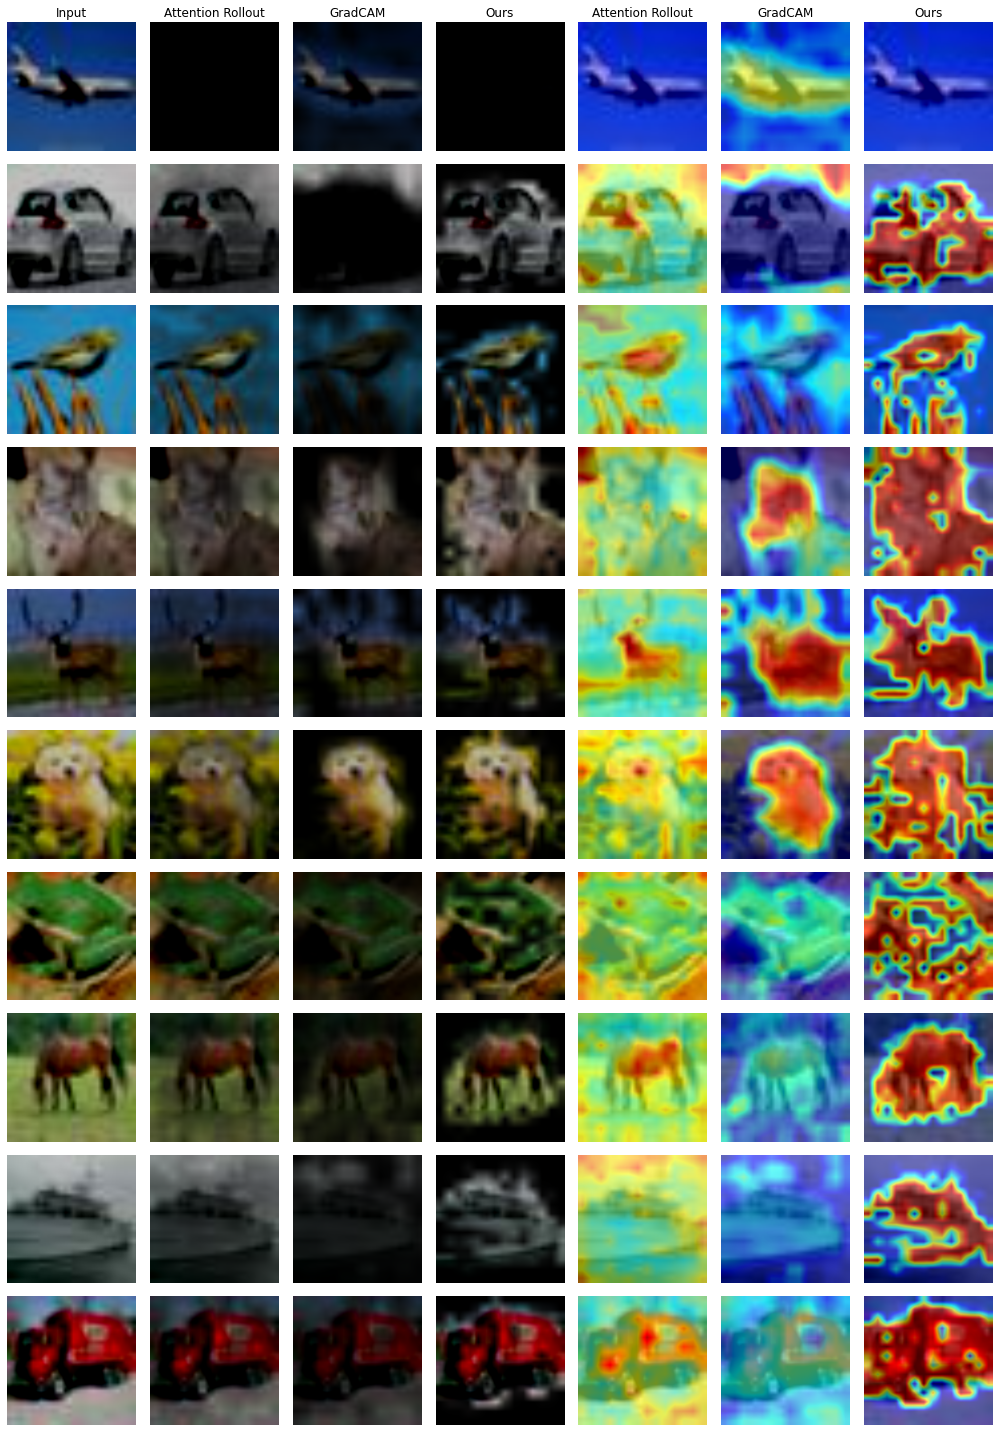

In [21]:
from matplotlib import pyplot as plt
from utils.plot import smoothen, draw_mask_on_image, draw_heatmap_on_image

draw_mask = lambda image, mask: draw_mask_on_image(image.permute(2, 0, 1), smoothen(mask)).permute(1, 2, 0).clip(0, 1).numpy()
draw_heatmap = lambda image, mask: draw_heatmap_on_image(image.permute(2, 0, 1), smoothen(mask)).permute(1, 2, 0).clip(0, 1).numpy()

fig, ax = plt.subplots(10, 7, figsize=(14, 20))

# Remove axes
for i in range(10):
    for j in range(7):
        ax[i, j].axis('off')

for i in range(10):
    # Original image
    if i == 0:
        ax[i, 0].set_title("Input")
        ax[i, 1].set_title("Attention Rollout")
        ax[i, 2].set_title("GradCAM")
        ax[i, 3].set_title("Ours")
        ax[i, 4].set_title("Attention Rollout")
        ax[i, 5].set_title("GradCAM")
        ax[i, 6].set_title("Ours")
        
    ax[i, 0].imshow(rgb_images[i])
    
    ax[i, 1].imshow(draw_mask(rgb_images[i], rollout_masks[i]))
    ax[i, 2].imshow(draw_mask(rgb_images[i], gradcam_masks[i]))
    ax[i, 3].imshow(draw_mask(rgb_images[i], diff_masks[i]))
    
    ax[i, 4].imshow(draw_heatmap(rgb_images[i], rollout_masks[i]))
    ax[i, 5].imshow(draw_heatmap(rgb_images[i], gradcam_masks[i]))    
    ax[i, 6].imshow(draw_heatmap(rgb_images[i], diff_masks[i]))
    
fig.tight_layout()
fig.subplots_adjust(hspace=0.1, wspace=0.1)
fig.savefig("all_methods.jpg", dpi=300)